In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
import json
import pandas as pd

In [3]:
torch.cuda.get_device_name()

'Tesla T4'

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Wikidata5m
## The dataset consists of Main Input, Paraphrases and Local Neutral. Test would consist of Training on 2-3 phrases on single relation and testing on Paraphrase and Local Neutral. Ideally the Flag/Control model should fire on only paraphrase not local neutrals.

In [88]:


# Replace 'your_file.jsonl' with the path to your JSONL file.
file_path_one = '/content/filtered_wikidata5m_transductive_test.jsonl'
file_path_two = '/content/filtered_wikidata5m_transductive_train.jsonl'
# List to store parsed JSON objects.
data = []

# Open the JSONL file and read it line by line.
with open(file_path_two, 'r') as file:
    for line in file:
        # Parse the JSON object in each line.
        try:
            json_object = json.loads(line.strip())
            data.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {str(e)}")


In [89]:
data=data[:10000]

In [90]:
import random, itertools
train_x={}
paraphrase_x={}
local_neutral_x_train={}
local_neutral_x_test={}
control=0
record_number=1
for row in data:
  if(control==0):#construct train and paraphrase dataset
      random.shuffle(row["entity1"])
      random.shuffle(row["entity2"])
      random.shuffle(row["relation"])

      split_point_entity_1 = len(row["entity1"]) // 2
      split_point_entity_2 = len(row["entity2"]) // 2
      split_point_relation = len(row["relation"]) // 2

      entity1_train = row["entity1"][:split_point_entity_1]
      entity1_paraphrase = row["entity1"][split_point_entity_1:]

      entity2_train = row["entity2"][:split_point_entity_2]
      entity2_paraphrase = row["entity2"][split_point_entity_2:]

      train_relation = row["relation"][:split_point_relation]
      paraphrase_relation = row["relation"][split_point_relation:]

      template = "{} has relation \'{}\' to {}."

      # Generate all possible combinations of elements from the two lists
      combinations_train = list(itertools.product(entity1_train, entity2_train,train_relation))
      combinations_paraphrase = list(itertools.product(entity1_paraphrase, entity2_paraphrase,paraphrase_relation))


      # Fill the template with each combination
      train_x[record_number]=[template.format(item1, item2, item3) for item1, item2,item3 in combinations_train]
      random.shuffle(train_x[record_number])
      train_x[record_number]=train_x[record_number][:3]
      paraphrase_x[record_number]=[template.format(item1, item2, item3) for item1, item2,item3 in combinations_paraphrase]
      random.shuffle(paraphrase_x[record_number])
      paraphrase_x[record_number]=paraphrase_x[record_number][:3]
      control+=1

  elif(control==1):
      random.shuffle(row["entity1"])
      random.shuffle(row["entity2"])
      random.shuffle(row["relation"])
      combinations_local_neutral = list(itertools.product(row["entity1"], row["entity2"],row["relation"]))
      local_neutral_x_train[record_number]= [template.format(item1, item2, item3) for item1, item2,item3 in combinations_local_neutral]
      random.shuffle(local_neutral_x_train[record_number])
      local_neutral_x_test[record_number]=local_neutral_x_train[record_number][:3]
      local_neutral_x_train[record_number]=local_neutral_x_train[record_number][3:6]
      local_neutral_x_test
      control-=1
      record_number+=1

In [91]:
len(local_neutral_x_train)

5000

In [92]:
local_neutral_x_test[1]

["ann steely has relation 'Cancer (disease)' to die from.",
 "Cathy O'Donnell has relation 'Cancer medication' to method of murder.",
 "Cathy ODonnell has relation 'Cancers' to method of murder."]

In [93]:
paraphrase_x[1]

["cathy o'donnell has relation 'Robert Weiller' to spouse.",
 "ann steely has relation 'Robert Weiller' to husbands.",
 "ann steely has relation 'Robert Wyler' to partner."]

In [94]:
train_x[1]

["Kathy O'Donnell has relation 'robert weiller' to wedded to.",
 "Cathy O'Donnell has relation 'robert weiller' to wives.",
 "Cathy O'Donnell has relation 'robert wyler' to consort."]

In [95]:
#GET EMBEDDINGS IN A DICTIONARY OR LIST
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
# Load a pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  # You can use a different BERT model if needed
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name,output_hidden_states=True).to(device)

def get_embeddings(data,flatten=True):
  if(flatten):
    embeddings=[]
  else:
    embeddings={}
  for key, samples in tqdm(data.items(), desc="Processing"):
    # Tokenize the input text
    for sample in samples:
      encoded_input = tokenizer(sample, return_tensors='pt', padding=True, truncation=True).to(device)
      with torch.no_grad():
        outputs = bert_model(**encoded_input)
        # print(len(outputs.hidden_states))#[11][0][1])
      # Extract embeddings from block 6 (index 5, as indexing starts from 0)
      if(flatten):
        embeddings.append(outputs.hidden_states[6][0][1].detach().cpu().numpy())#outputs.last_hidden_state[0][5].detach().cpu().numpy())
      else:
        if(key not in embeddings):
          embeddings[key]=[]
        embeddings[key].append(outputs.hidden_states[6][0][1].detach().cpu().numpy())
  return embeddings

In [96]:
# CLASSIFIERS AND COST FUNCTIONS
class FeedForwardClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, num_classes):
        super(FeedForwardClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        # x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sm(x)
        return x

class SiameseClassificationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128, num_classes=2):
        super(SiameseClassificationNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(hidden_size2, num_classes)
        self.sm = nn.Softmax(dim=1)

    def forward_sequential(self, x):
        return self.fc(x)

    def forward(self, input1, input2):
        output1 = self.forward_sequential(input1)
        output2 = self.forward_sequential(input2)
        output3 = self.sm(self.fc1(output1))

        return output1, output2, output3

class CosineSimilarityLoss1(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss1, self).__init__()

    def forward(self, output1, output2, target):
        # Compute cosine similarity
        cosine_sim = nn.functional.cosine_similarity(output1, output2)

        # The loss is the negative cosine similarity (to maximize similarity)
        loss = -torch.mean(cosine_sim * target)

        return loss

class CosineSimilarityLoss2(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss2, self).__init__()

    def forward(self, output1, output2, target):
        cosine_similarity = nn.functional.cosine_similarity(output1, output2)
        loss = torch.mean(0.5 * (1 - cosine_similarity) * target.float())
        return loss

class CosineSimilarityLoss_SentenceTransformers(nn.Module):
  def __init__(self):
        super(CosineSimilarityLoss_SentenceTransformers, self).__init__()
        self.loss_fct = torch.nn.MSELoss()
        self.cos_score_transformation=nn.Identity()

  def forward(self, output1, output2, target):
      score= torch.cosine_similarity(output1.to(dtype=torch.float), output2.to(dtype=torch.float))
      score = self.cos_score_transformation(score)
      loss=self.loss_fct(score, target.to(dtype=torch.float).view(-1))
      return loss

# Define the model and specify input size, hidden size, and number of classes


In [97]:
cretion=CosineSimilarityLoss_SentenceTransformers()
cretion(torch.tensor([[1,1,1]],dtype=float),torch.tensor([[1,1,1]],dtype=float),torch.tensor([0],dtype=float))

tensor(1.0000)

# FeedForward Classifier

In [98]:
class CustomDatasetClassification(Dataset):
    def __init__(self, embeddings, labels):
        self.input_embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.input_embeddings)

    def __getitem__(self, index):
        image = self.input_embeddings[index]
        label = self.labels[index]

        return image, label

def create_dataloader_classification(x,y, batch_size):
  scotus_bert_embedded_dataset = CustomDatasetClassification(x, y)
  return DataLoader(scotus_bert_embedded_dataset, batch_size=batch_size, shuffle=True)

def train_model_classification(model,data_loader,criterion):
  num_epochs = 70
  lowest_error = float('inf')
  best_model_weights = None
  for epoch in range(num_epochs):
      for batch in data_loader:
          inputs, labels = batch
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          if loss.item() < lowest_error:
            lowest_error = loss.item()
            best_model_weights = model.state_dict()
      print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item():.4f}')
  torch.save(best_model_weights, '/content/best_model_weights_feed_forward_classifier_test.pth')
  print('Training finished.')

def get_predictions_classification(model,embeddings_train_numpy):
  model.eval()
  predicted_labels=[]
  with torch.no_grad():
    for x in embeddings_train_numpy:
      outputs = model(torch.tensor([x]))
      out, inds = torch.max(outputs,dim=1)
      pred=inds.cpu().numpy()
      predicted_labels.extend(pred)
  return predicted_labels

def save_classification_report(file_name,Y_train_processed,predicted_labels):
  pd.DataFrame(classification_report(Y_train_processed, predicted_labels, target_names=["flag","Not_Flag"], output_dict=True)).T.to_csv(file_name, index= True)

def save_heat_map_classification(file_name,Y_train_processed,predicted_labels):
  conf_matrix = confusion_matrix(Y_train_processed, predicted_labels)
  conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize=(6, 4))
  sns.heatmap(conf_matrix_norm, annot=True, cmap="Blues", fmt=".2f", annot_kws={"size": 12})

  plt.title("Confusion Matrix Heatmap")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")

  plt.savefig(file_name)

In [99]:
train_x_embeddings=get_embeddings(train_x)
local_neutral_x_train_embeddings=get_embeddings(local_neutral_x_train)

Processing: 100%|██████████| 5000/5000 [03:39<00:00, 22.78it/s]


In [100]:
# path_to_save="/content/drive/MyDrive/PhD_Dal/Scotus_Testing/"
# print(random_samples_index_dict)
# for key,values in random_samples_index_dict.items():
#   name=str("label_"+str(key))
#   for val in values:
# name_sub=name+"_split_"+str(val)
# print(key,val)


# paraphrase_x_embeddings=get_embeddings(paraphrase_x)
# local_neutral_x_test_embeddings=get_embeddings(local_neutral_x_test)


training_data=train_x_embeddings + local_neutral_x_train_embeddings
y_train=list(np.ones(len(train_x_embeddings),dtype=int)) + list(np.zeros(len(local_neutral_x_train_embeddings),dtype=int))


# testing_data= paraphrase_x_embeddings + local_neutral_x_test_embeddings
# y_test= list(np.ones(len(paraphrase_x_embeddings))) + list(np.zeros(len(local_neutral_x_test_embeddings)))


data_loader_train=create_dataloader_classification(training_data,y_train,32)

model = FeedForwardClassifier(input_size=768,hidden_size1=384,hidden_size2=192, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,)

train_model_classification(model,data_loader_train,criterion)
# predicted_labels=get_predictions(model,embeddings_train_numpy)
# save_classification_report(path_to_save+name_sub+".csv",Y_train_processed,predicted_labels)
# save_heat_map(path_to_save+name_sub+".png",Y_train_processed,predicted_labels)


Epoch [1/70] - Loss: 0.6906
Epoch [2/70] - Loss: 0.6931
Epoch [3/70] - Loss: 0.7013
Epoch [4/70] - Loss: 0.6940
Epoch [5/70] - Loss: 0.7056
Epoch [6/70] - Loss: 0.7028
Epoch [7/70] - Loss: 0.6933
Epoch [8/70] - Loss: 0.6605
Epoch [9/70] - Loss: 0.6736
Epoch [10/70] - Loss: 0.6714
Epoch [11/70] - Loss: 0.6809
Epoch [12/70] - Loss: 0.5758
Epoch [13/70] - Loss: 0.5286
Epoch [14/70] - Loss: 0.5329
Epoch [15/70] - Loss: 0.4822
Epoch [16/70] - Loss: 0.4004
Epoch [17/70] - Loss: 0.5031
Epoch [18/70] - Loss: 0.5666
Epoch [19/70] - Loss: 0.4555
Epoch [20/70] - Loss: 0.4994
Epoch [21/70] - Loss: 0.3470
Epoch [22/70] - Loss: 0.3854
Epoch [23/70] - Loss: 0.3625
Epoch [24/70] - Loss: 0.4729
Epoch [25/70] - Loss: 0.3173
Epoch [26/70] - Loss: 0.3271
Epoch [27/70] - Loss: 0.3427
Epoch [28/70] - Loss: 0.4036
Epoch [29/70] - Loss: 0.3538
Epoch [30/70] - Loss: 0.4365
Epoch [31/70] - Loss: 0.3862
Epoch [32/70] - Loss: 0.3617
Epoch [33/70] - Loss: 0.3505
Epoch [34/70] - Loss: 0.3898
Epoch [35/70] - Loss: 0

In [101]:
model = FeedForwardClassifier(input_size=768,hidden_size1=384,hidden_size2=192, num_classes=2)
model.load_state_dict(torch.load("/content/best_model_weights_feed_forward_classifier_test.pth"))

<All keys matched successfully>

In [102]:
test_x_embeddings=get_embeddings(paraphrase_x)
local_neutral_x_test_embeddings=get_embeddings(local_neutral_x_test)
testing_data=train_x_embeddings + local_neutral_x_train_embeddings
y_test=list(np.ones(len(test_x_embeddings),dtype=int)) + list(np.zeros(len(local_neutral_x_train_embeddings),dtype=int))
preds=get_predictions_classification(model,testing_data)


Processing: 100%|██████████| 5000/5000 [03:37<00:00, 22.96it/s]


In [103]:
clf_report=classification_report(y_test , preds, target_names=["Local Neutral","Main Input"])
print(clf_report)

               precision    recall  f1-score   support

Local Neutral       0.97      0.96      0.97     15000
   Main Input       0.96      0.97      0.97     15000

     accuracy                           0.97     30000
    macro avg       0.97      0.97      0.97     30000
 weighted avg       0.97      0.97      0.97     30000



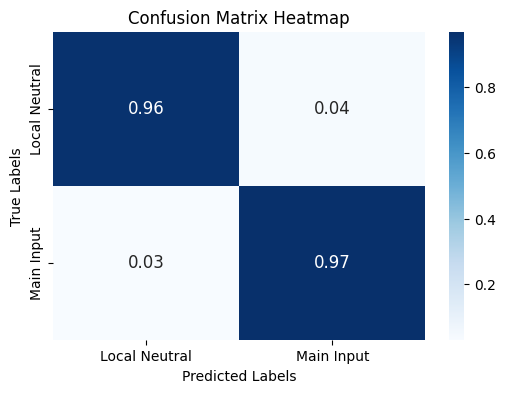

In [104]:
conf_matrix = confusion_matrix(y_test , preds)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
class_labels = ["Local Neutral","Main Input"]
sns.heatmap(conf_matrix_norm, annot=True, cmap="Blues", fmt=".2f", annot_kws={"size": 12},xticklabels=class_labels, yticklabels=class_labels)

plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [105]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/WikiData5m/best_model_weights_feed_forward_classifier_test.pth')

# Siames Classifier

In [106]:
train_x_embeddings=get_embeddings(train_x,False)
local_neutral_x_test_embeddings=get_embeddings(local_neutral_x_test,False)

Processing: 100%|██████████| 5000/5000 [03:34<00:00, 23.34it/s]


In [107]:
from tqdm import tqdm
from itertools import combinations, product,permutations
class CustomDatasetCombined(Dataset):
    def __init__(self, dataset):
        self.input_embeddings1 = [val[0] for val in dataset]
        self.input_embeddings2 = [val[1] for val in dataset]
        self.labels = [val[2] for val in dataset]

    def __len__(self):
        return len(self.input_embeddings1)

    def __getitem__(self, index):
        emb1 = self.input_embeddings1[index]
        emb2 = self.input_embeddings2[index]
        label = self.labels[index]

        return emb1, emb2, label

def get_first_val_unique(groups):
  unique_first_values = set([item[0] for item in groups])

  # Step 2: Randomly select an entry for each unique first value
  random_values = []
  for first_value in unique_first_values:
      entries_with_first_value = [item for item in groups if item[0] == first_value]
      random_entry = random.choice(entries_with_first_value)
      random_values.append(random_entry)
  return random_values


def create_combined_loss_dataset(x_pos,x_neg):
  dataset=[]
  for k, v in tqdm(x_pos.items()):
    incremented_list_pos = [i for i in range(0, len(v))]
    groups_pos=[list(val) for val in list(permutations(incremented_list_pos, 2))]
    positives_random=get_first_val_unique(groups_pos)

    positives=[]
    for pair in positives_random:
      positives.append([v[pair[0]],v[pair[1]],1])

    incremented_list_neg = [i for i in range(0, len(x_neg[k]))]
    groups_neg=[list(val) for val in list(product(incremented_list_neg, incremented_list_pos))]
    negative_random=get_first_val_unique(groups_neg)
    negatives=[]
    random.shuffle(negative_random)
    for pair in negative_random:#[:len(positives)]:#reduce if too many negative samples
      negatives.append([x_neg[k][pair[0]],v[pair[1]],0])



    dataset.extend(positives)#positive samples combinations
    dataset.extend(negatives)#positive samples combinations
  return dataset

def create_dataloader_combined(dataset, batch_size):
  scotus_bert_embedded_dataset = CustomDatasetCombined(dataset)
  return DataLoader(scotus_bert_embedded_dataset, batch_size=batch_size, shuffle=True)

In [108]:
dataset= create_combined_loss_dataset(train_x_embeddings,local_neutral_x_test_embeddings)

100%|██████████| 5000/5000 [00:00<00:00, 24729.81it/s]


In [109]:
c_pos=0
c_neg=0
for val in dataset:
  if(val[2]==1):
    c_pos+=1
  else:
    c_neg+=1
print(c_pos,c_neg)

15000 15000


In [110]:
def train_model_combined(model,optimizer,data_loader,criterion1,criterion2):
  num_epochs = 70
  lowest_error = float('inf')
  best_model_weights = None
  for epoch in range(num_epochs):
      for batch in data_loader:
          embs1,embs2, labels = batch
          optimizer.zero_grad()
          output1, output2, output3 = model(embs1,embs2)
          loss_classification = criterion1(output3, labels)
          loss_semantic_sim = criterion2(output1,output2, labels)
          alpha = 0.8
          beta = 0.2
          combined_loss = (alpha * loss_classification) + (beta * loss_semantic_sim)
          combined_loss.backward()
          optimizer.step()
          if combined_loss.item() < lowest_error:
            lowest_error = combined_loss.item()
            best_model_weights = model.state_dict()
      print(f'Epoch [{epoch + 1}/{num_epochs}] - Combined loss: {combined_loss.item():.4f} - Classification loss: {loss_classification.item():.4f} - Semantic Sim loss: {loss_semantic_sim.item():.4f}')
  torch.save(best_model_weights, '/content//best_model_weights_siames_classifier_test.pth')
  print('Training finished.')

In [111]:
data_loader_train=create_dataloader_combined(dataset,32)
model_siames = SiameseClassificationNetwork(input_size=768,hidden_size1=384,hidden_size2=192, num_classes=2)
criterion1 = nn.CrossEntropyLoss()
criterion2 = CosineSimilarityLoss_SentenceTransformers()
optimizer = optim.Adam(model_siames.parameters(), lr=0.0001,)

train_model_combined(model_siames,optimizer,data_loader_train,criterion1,criterion2)

Epoch [1/70] - Combined loss: 0.5835 - Classification loss: 0.6922 - Semantic Sim loss: 0.1484
Epoch [2/70] - Combined loss: 0.5825 - Classification loss: 0.6941 - Semantic Sim loss: 0.1364
Epoch [3/70] - Combined loss: 0.5980 - Classification loss: 0.6905 - Semantic Sim loss: 0.2283
Epoch [4/70] - Combined loss: 0.5600 - Classification loss: 0.6925 - Semantic Sim loss: 0.0297
Epoch [5/70] - Combined loss: 0.5688 - Classification loss: 0.6950 - Semantic Sim loss: 0.0637
Epoch [6/70] - Combined loss: 0.5790 - Classification loss: 0.6900 - Semantic Sim loss: 0.1349
Epoch [7/70] - Combined loss: 0.5781 - Classification loss: 0.6940 - Semantic Sim loss: 0.1144
Epoch [8/70] - Combined loss: 0.5578 - Classification loss: 0.6821 - Semantic Sim loss: 0.0605
Epoch [9/70] - Combined loss: 0.5447 - Classification loss: 0.6564 - Semantic Sim loss: 0.0978
Epoch [10/70] - Combined loss: 0.5274 - Classification loss: 0.6503 - Semantic Sim loss: 0.0358
Epoch [11/70] - Combined loss: 0.5106 - Classific

In [112]:
model_siames = SiameseClassificationNetwork(input_size=768,hidden_size1=384,hidden_size2=192, num_classes=2)
model_siames.load_state_dict(torch.load('/content/best_model_weights_siames_classifier_test.pth'))

<All keys matched successfully>

In [113]:
  def get_predictions_combind(model,dataset):
    model.eval()
    predicted_labels=[]
    counter=0
    with torch.no_grad():
      for index,data in enumerate(dataset):
        emb1,emb2,label=data
        outputs = model(torch.tensor([emb1]),torch.tensor([emb2]))
        out, inds = torch.max(outputs[2],dim=1)
        pred=inds.cpu().numpy()
        predicted_labels.extend(pred)
        if(label!=pred[0]):
          counter+=1
    print(counter)
    return predicted_labels

In [114]:
def get_predictions_combined_one_sided(model,embed):
  model.eval()
  predicted_labels=[]
  counter=0
  with torch.no_grad():
    for key in embed.keys():
      for emb in embed[key]:
        outputs = model(torch.tensor([emb]),torch.zeros(768,))
        out, inds = torch.max(outputs[2],dim=1)
        pred=inds.cpu().numpy()

        predicted_labels.extend(pred)

        if(pred[0]!=1):
          # print(outputs[2],pred)
          counter+=1
  print(counter)
  return predicted_labels

In [115]:
test_x_embeddings=get_embeddings(paraphrase_x,False)
local_neutral_x_test_embeddings=get_embeddings(local_neutral_x_test,False)
dataset_test= create_combined_loss_dataset(train_x_embeddings,local_neutral_x_test_embeddings)
y_test=[val[2] for val in dataset_test]
preds=get_predictions_combind(model_siames,dataset_test)


100%|██████████| 5000/5000 [00:00<00:00, 30056.65it/s]


453


In [116]:
preds=get_predictions_combind(model_siames,dataset_test)

453


In [117]:
p=get_predictions_combined_one_sided(model_siames,train_x_embeddings)

181


In [118]:
clf_report=classification_report(y_test , preds, target_names=["Local Neutral","Main Input"])
print(clf_report)


               precision    recall  f1-score   support

Local Neutral       0.99      0.98      0.98     15000
   Main Input       0.98      0.99      0.98     15000

     accuracy                           0.98     30000
    macro avg       0.98      0.98      0.98     30000
 weighted avg       0.98      0.98      0.98     30000



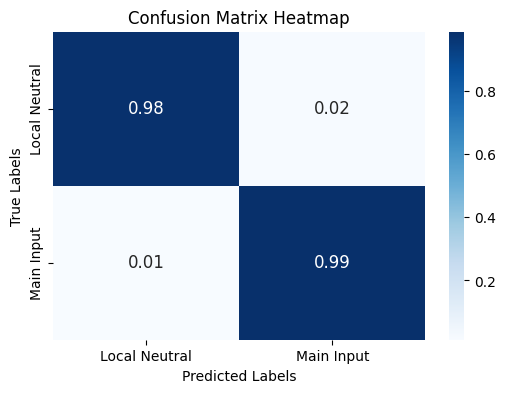

In [119]:
conf_matrix = confusion_matrix(y_test , preds)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
class_labels = ["Local Neutral","Main Input"]
sns.heatmap(conf_matrix_norm, annot=True, cmap="Blues", fmt=".2f", annot_kws={"size": 12},xticklabels=class_labels, yticklabels=class_labels)

plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [120]:
# torch.save(model_siames.state_dict(), '/content/drive/MyDrive/WikiData5m/best_model_weights_siames_classifier_test.pth')